In [1]:
import lightkurve as lk
%matplotlib inline
import starry
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib.gridspec as gridspec
import pymc3 as pm
import pymc3_ext as pmx
import theano.tensor as tt
import exoplanet as xo

In [2]:
starry.config.lazy = False
starry.config.quiet = True

In [333]:
search_result = lk.search_lightcurve('HAT-P-11', author='Kepler', cadence='short')
# Download all available Kepler light curves
lc_collection = search_result.download_all()
# lc_collection.plot();

In [178]:
search_result.year

array([2009, 2009, 2009, 2009, 2009, 2009, 2009, 2009, 2010, 2010, 2010,
       2010, 2010, 2010, 2010, 2010, 2010, 2011, 2011, 2011, 2011, 2011,
       2011, 2012, 2012, 2012, 2012, 2012, 2012, 2012, 2012, 2012, 2013,
       2013, 2013, 2013, 2013])

In [334]:
lc1 = search_result[search_result.year == 2009].download_all()
lc3 = search_result[search_result.year == 2010].download_all()
lc4 = search_result[search_result.year == 2012].download_all()
lc2 = search_result[search_result.year == 2010].download_all() 

In [335]:
lc1 = lc1.stitch()
lc3 = lc3.stitch()
lc4 = lc4.stitch()
lc2 = lc2.stitch()
all_lc = lc_collection.stitch()

<AxesSubplot:xlabel='Time - 2454833 [BKJD days]', ylabel='Normalized Flux'>

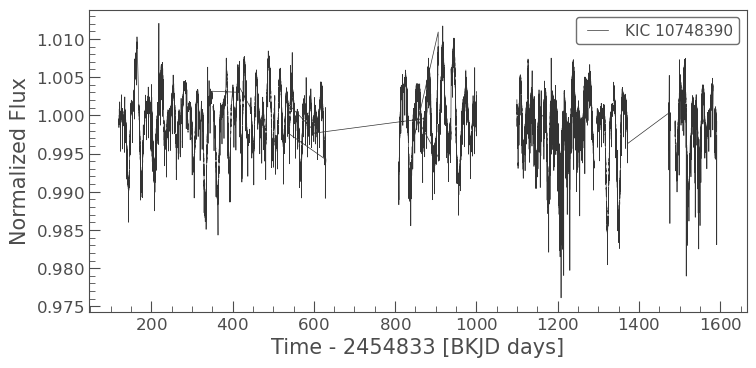

In [181]:
all_lc.plot()

In [323]:
period = np.linspace(2, 20, 10000)
bls = all_lc.to_periodogram(method='bls', period=period, frequency_factor=500);
planet_period = bls.period_at_max_power
planet_t0 = bls.transit_time_at_max_power
planet_dur = bls.duration_at_max_power*1.5
# print(period)

In [111]:
planet_period

<Quantity 4.88748875 d>

In [112]:
planet_t0

<Time object: scale='tdb' format='bkjd' value=124.85859840558085>

<AxesSubplot:xlabel='Period [$\\mathrm{d}$]', ylabel='BLS Power'>

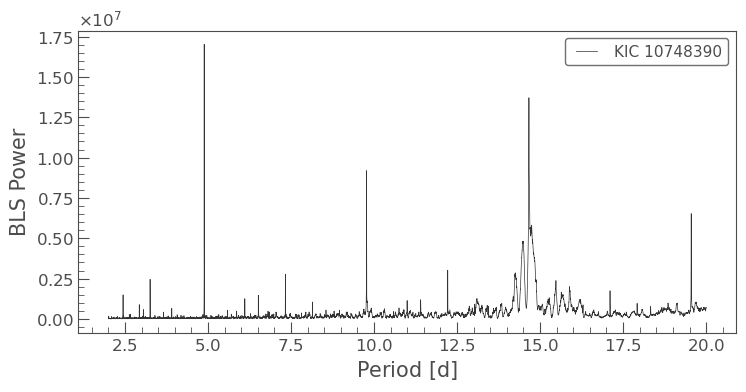

In [113]:
bls.plot()

# Cleaning the data

In [336]:
all_lc=all_lc.remove_nans()

In [337]:
tranmask = all_lc.create_transit_mask(transit_time=planet_t0.value, period=np.float64(planet_period), duration=np.float64(planet_dur))

In [308]:
tmp = np.array(all_lc.flatten(mask=tranmask).flux)

In [309]:
tmpt = all_lc.time.value

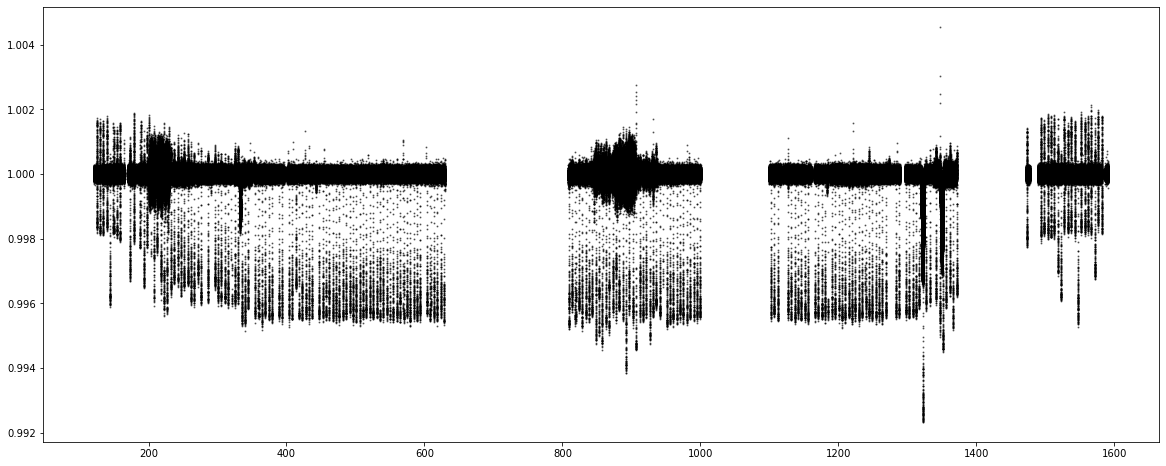

In [310]:
plt.figure(figsize=(20, 8))
plt.plot(tmpt, tmp, "k.", ms=2, alpha=0.5)

(201.0, 231.0)

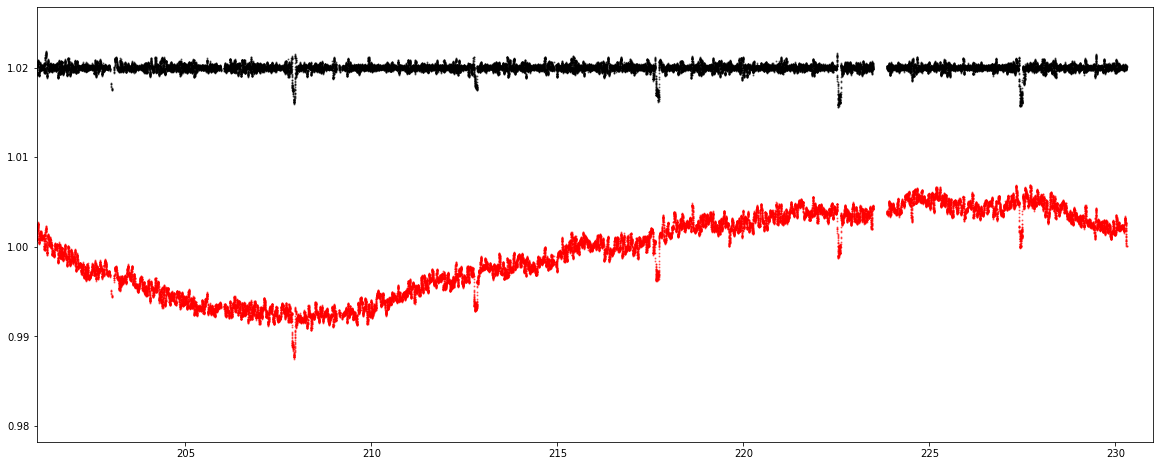

In [317]:
plt.figure(figsize=(20, 8))

idx = slice(None, None, None) #all_lc.quality == 0
# idx = slice(500,600)
plt.plot(tmpt[idx], all_lc.flux[idx], "r.", ms=2, alpha=0.5)
plt.plot(tmpt[idx], 0.02 + tmp[idx], "k.", ms=2, alpha=0.5)
plt.xlim(201, 231)

(1200.0, 1250.0)

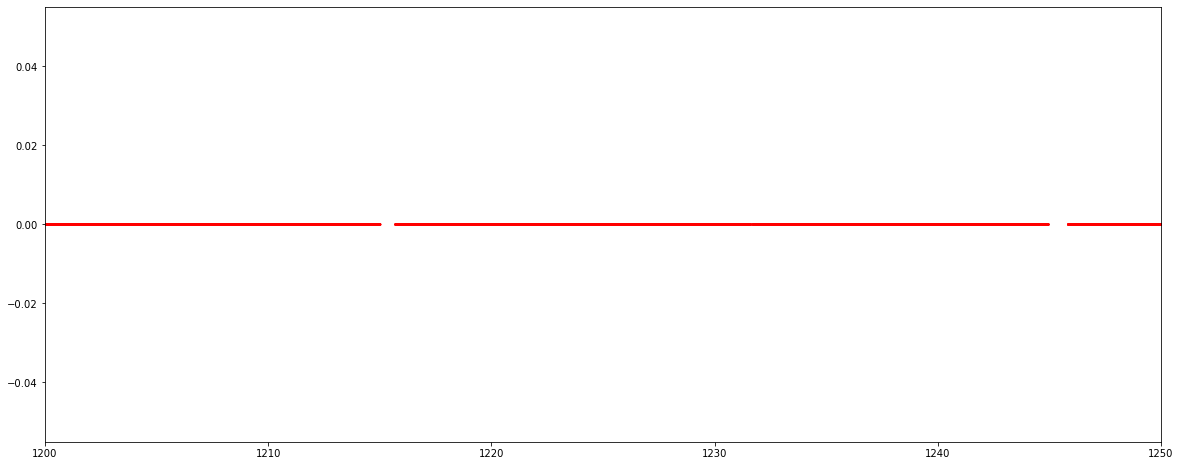

In [312]:
plt.figure(figsize=(20, 8))
plt.plot(tmpt, all_lc.quality, "r.", ms=2, alpha=0.5)
plt.xlim(1200, 1250)

In [338]:
all_lc = all_lc[all_lc.quality==0]

(1200.0, 1250.0)

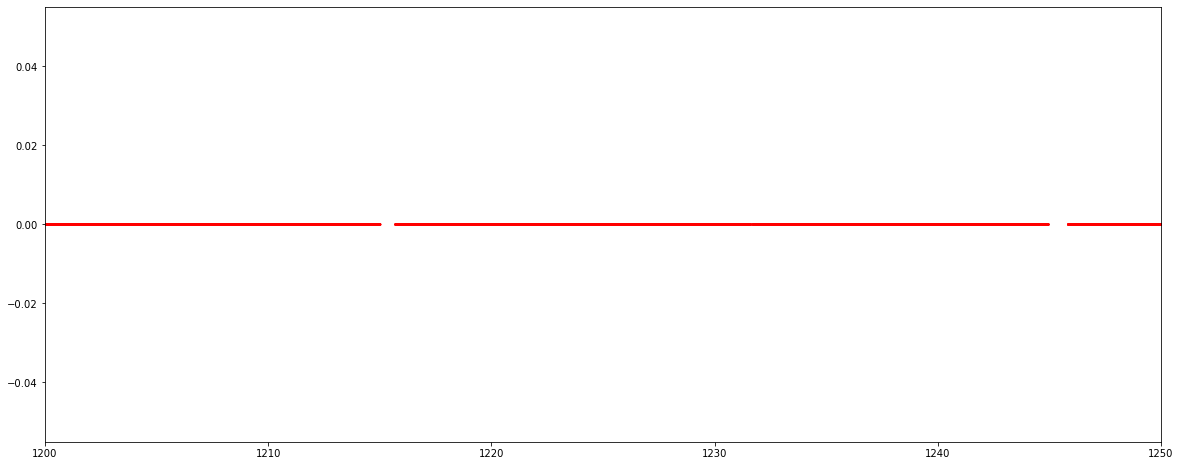

In [314]:
plt.figure(figsize=(20, 8))
plt.plot(all_lc.time.value, all_lc.quality, "r.", ms=2, alpha=0.5)
plt.xlim(1200, 1250)

In [339]:
clean_mask = (all_lc.time.value >= 201) & (all_lc.time.value <=231) & (all_lc.time.value >= 847) & (all_lc.time.value <=905) & (all_lc.time.value >= 1337) & (all_lc.time.value <=1372) 
all_lc[~clean_mask] 

time,flux,flux_err,quality,timecorr,centroid_col,centroid_row,cadenceno,sap_flux,sap_flux_err,sap_bkg,sap_bkg_err,pdcsap_flux,pdcsap_flux_err,sap_quality,psf_centr1,psf_centr1_err,psf_centr2,psf_centr2_err,mom_centr1,mom_centr1_err,mom_centr2,mom_centr2_err,pos_corr1,pos_corr2
,,,,d,pix,pix,,electron / s,electron / s,electron / s,electron / s,electron / s,electron / s,,pix,pix,pix,pix,pix,pix,pix,pix,pix,pix
Time,float32,float32,int32,float32,float64,float64,int32,float32,float32,float32,float32,float32,float32,int32,float64,float32,float64,float32,float64,float32,float64,float32,float32,float32
120.52859840558085,9.9879408e-01,1.7174082e-04,0,3.223656e-04,555.58158,821.86413,5500,2.9128242e+06,2.3517690e+02,6.8893467e+03,2.1677258e+00,2.9205592e+06,5.0218484e+02,0,———,———,———,———,555.58158,6.6864952e-05,821.86413,1.9141044e-04,2.5442394e-04,-3.2165432e-03
120.53064188249846,9.9873668e-01,1.5708857e-04,0,3.224425e-04,555.58274,821.86521,5503,2.9126892e+06,2.3516835e+02,6.8900498e+03,2.1674051e+00,2.9203915e+06,4.5934039e+02,0,———,———,———,———,555.58274,6.6847140e-05,821.86521,1.9152994e-04,2.8717262e-04,-3.1886860e-03
120.53132310817455,9.9864805e-01,1.5296284e-04,0,3.224682e-04,555.58130,821.86659,5504,2.9124402e+06,2.3514540e+02,6.8902847e+03,2.1672983e+00,2.9201322e+06,4.4727640e+02,0,———,———,———,———,555.58130,6.6857276e-05,821.86659,1.9131499e-04,2.9808990e-04,-3.1793993e-03
120.5320042338135,9.9875557e-01,1.4920715e-04,0,3.224938e-04,555.58338,821.86437,5505,2.9127630e+06,2.3516986e+02,6.8905190e+03,2.1671915e+00,2.9204468e+06,4.3629446e+02,0,———,———,———,———,555.58338,6.6841698e-05,821.86437,1.9159318e-04,3.0900558e-04,-3.1701140e-03
120.53268535945244,9.9870324e-01,1.4579581e-04,0,3.225195e-04,555.58280,821.86600,5506,2.9126190e+06,2.3516171e+02,6.8907529e+03,2.1670847e+00,2.9202938e+06,4.2631943e+02,0,———,———,———,———,555.58280,6.6839348e-05,821.86600,1.9150582e-04,3.1992130e-04,-3.1608287e-03
120.53336638509063,9.9869567e-01,1.4272092e-04,0,3.225451e-04,555.58323,821.86398,5507,2.9126050e+06,2.3516237e+02,6.8909873e+03,2.1669776e+00,2.9202715e+06,4.1732819e+02,0,———,———,———,———,555.58323,6.6845379e-05,821.86398,1.9158299e-04,3.3083538e-04,-3.1515448e-03
120.53472873640567,9.9866086e-01,1.3750856e-04,0,3.225964e-04,555.58307,821.86406,5509,2.9125182e+06,2.3515913e+02,6.8914561e+03,2.1667640e+00,2.9201698e+06,4.0208679e+02,0,———,———,———,———,555.58307,6.6847679e-05,821.86406,1.9156588e-04,3.5266837e-04,-3.1329729e-03
120.53540996204538,9.9870157e-01,1.3533853e-04,0,3.226220e-04,555.58220,821.86641,5510,2.9126435e+06,2.3516617e+02,6.8916904e+03,2.1666570e+00,2.9202888e+06,3.9574146e+02,0,———,———,———,———,555.58220,6.6860477e-05,821.86641,1.9145996e-04,3.6358566e-04,-3.1236862e-03


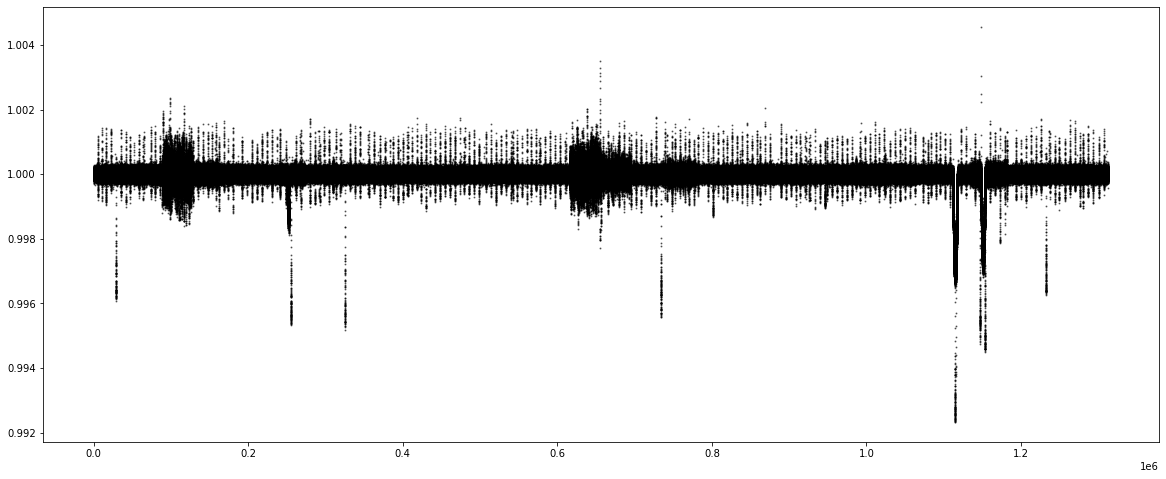

In [278]:
plt.figure(figsize=(20, 8))
plt.plot(all_lc[~clean_mask].flatten().flux, "k.", ms=2, alpha=0.5)

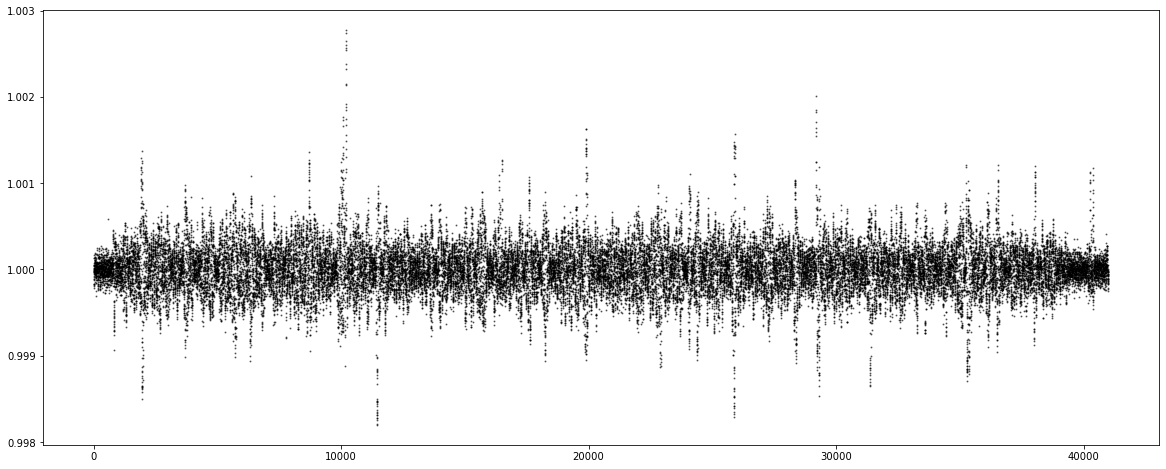

In [222]:
plt.figure(figsize=(20, 8))
plt.plot(all_lc[88000:129000].flatten().flux, "k.", ms=2, alpha=0.5)

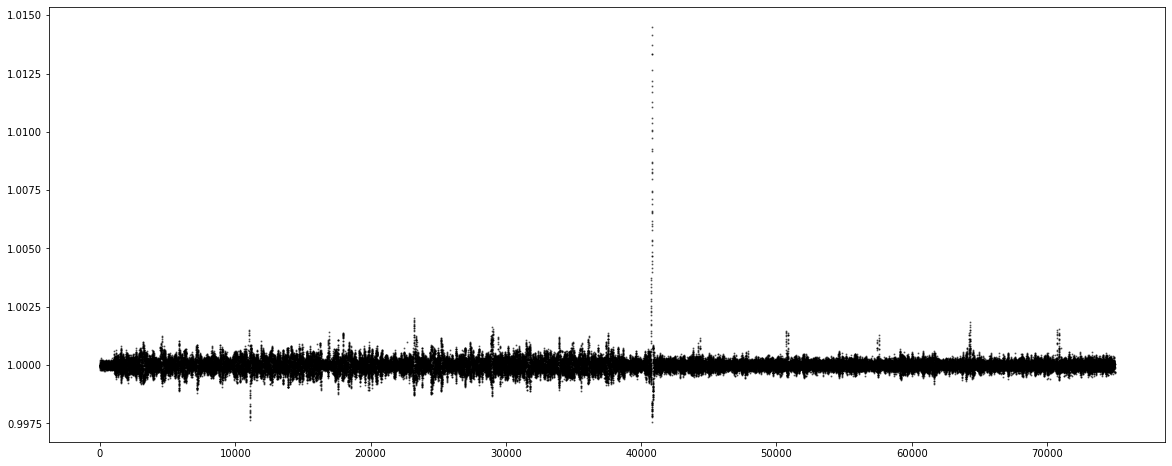

In [216]:
plt.figure(figsize=(20, 8))
plt.plot(all_lc[615000:690000].flatten().flux, "k.", ms=2, alpha=0.5)

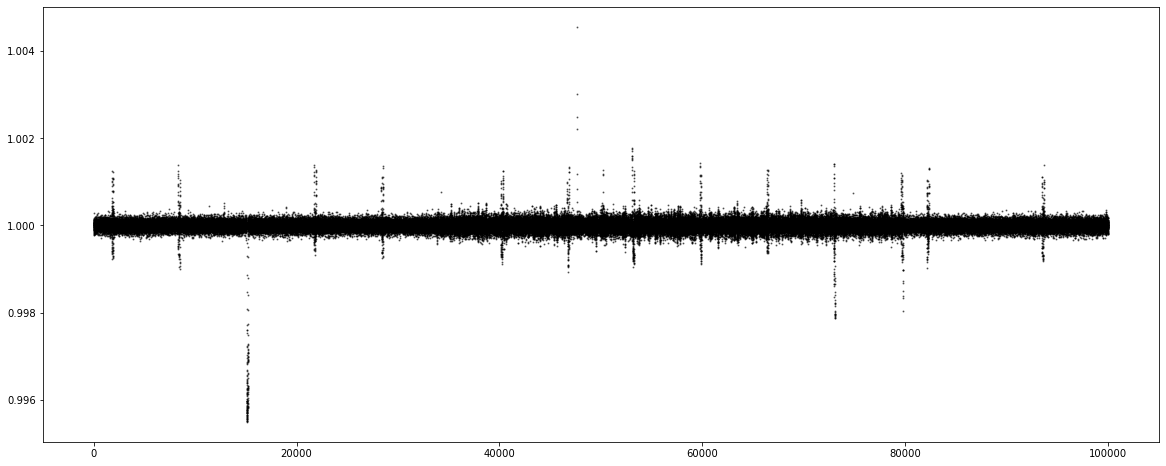

In [223]:
plt.figure(figsize=(20, 8))
plt.plot(all_lc[1100000:1200000].flatten().flux, "k.", ms=2, alpha=0.5)

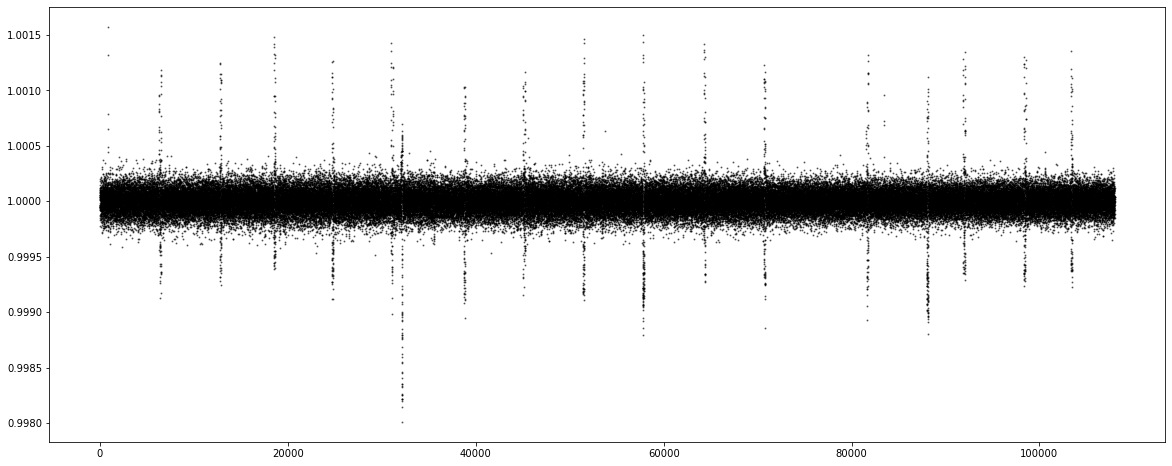

In [256]:
plt.figure(figsize=(20, 8))
plt.plot(all_lc[992000:1100000].flatten().flux, "k.", ms=2, alpha=0.5)

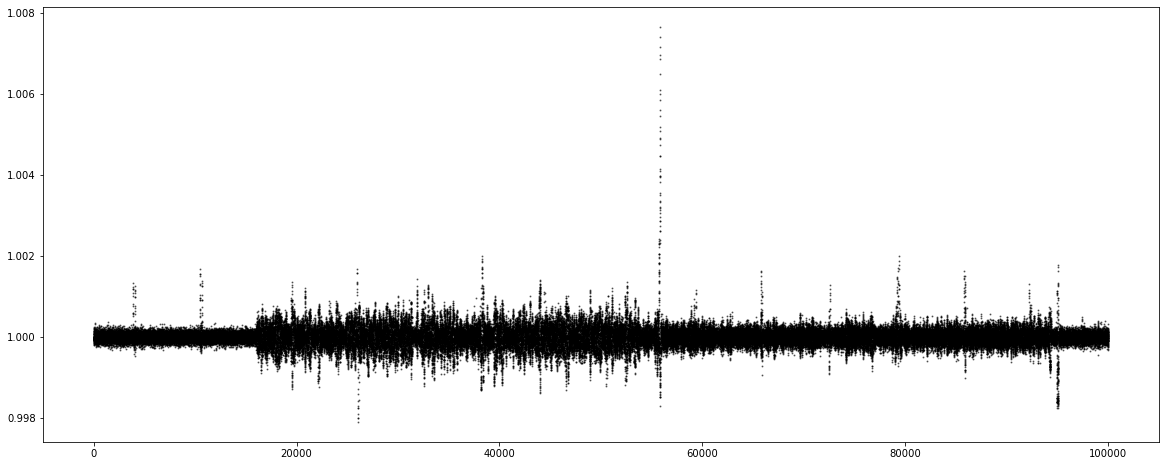

In [245]:
plt.figure(figsize=(20, 8))
plt.plot(all_lc[600000:700000].flatten().flux, "k.", ms=2, alpha=0.5)

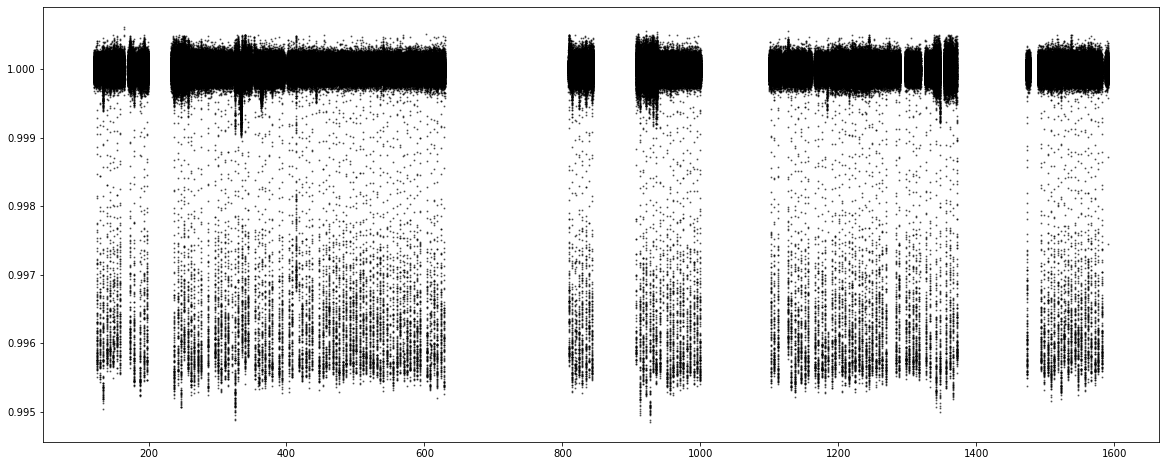

In [353]:
lc_temp = all_lc.copy()
lc_temp = lc_temp[~clean_mask]
lc_temp.flux.value[88000:129000] = np.nan
lc_temp.flux.value[615000:690000] = np.nan
lc_temp = lc_temp.remove_nans()
clean_mask1 = (lc_temp.time.value>1319) & (lc_temp.time.value<1325)
lc_temp = lc_temp[~clean_mask1]
clean_mask2 = (lc_temp.time.value>1347) & (lc_temp.time.value<1353)
lc_temp = lc_temp[~clean_mask2]
clean_mask3 = (lc_temp.time.value>331.5) & (lc_temp.time.value<334)
lc_temp = lc_temp[~clean_mask3]
clean_mask4 = (lc_temp.time.value>860) & (lc_temp.time.value<880)
lc_temp = lc_temp[~clean_mask4]
# tranmask = lc_temp.create_transit_mask(transit_time=planet_t0.value, period=np.float64(planet_period), duration=np.float64(planet_dur))
# clean_mask5 = lc_temp.flatten(mask=tranmask).flux>1.0005
# lc_temp = lc_temp[~clean_mask5]
tranmask = lc_temp.create_transit_mask(transit_time=planet_t0.value, period=np.float64(planet_period), duration=np.float64(planet_dur))
plt.figure(figsize=(20, 8))
plt.plot(lc_temp.time.value,lc_temp.flatten(mask=tranmask).flux, "k.", ms=2, alpha=0.5)
# plt.xlim(251,253)

In [350]:
lc_temp[lc_temp.flatten(mask=tranmask).flux>1.0005]

time,flux,flux_err,quality,timecorr,centroid_col,centroid_row,cadenceno,sap_flux,sap_flux_err,sap_bkg,sap_bkg_err,pdcsap_flux,pdcsap_flux_err,sap_quality,psf_centr1,psf_centr1_err,psf_centr2,psf_centr2_err,mom_centr1,mom_centr1_err,mom_centr2,mom_centr2_err,pos_corr1,pos_corr2
,,,,d,pix,pix,,electron / s,electron / s,electron / s,electron / s,electron / s,electron / s,,pix,pix,pix,pix,pix,pix,pix,pix,pix,pix
Time,float32,float32,int32,float32,float64,float64,int32,float32,float32,float32,float32,float32,float32,int32,float64,float32,float64,float32,float64,float32,float64,float32,float32,float32
140.60673525259335,9.9517775e-01,8.6864529e-05,0,1.088013e-03,555.57145,821.86074,34977,2.9109070e+06,2.3485545e+02,6.7127012e+03,2.2150123e+00,2.9069715e+06,2.5373628e+02,0,———,———,———,———,555.57145,6.5881984e-05,821.86074,1.9294168e-04,-2.5294735e-03,1.4602326e-02
143.64464481248433,9.9117458e-01,8.5003143e-05,0,1.202772e-03,555.57083,821.86260,39437,2.8937795e+06,2.3413205e+02,6.6745264e+03,2.2101557e+00,2.8952780e+06,2.4829907e+02,0,———,———,———,———,555.57083,6.5920867e-05,821.86260,1.9210286e-04,-2.1773125e-03,7.8232344e-03
164.9889775734555,1.0098723e+00,8.9528126e-05,0,1.963133e-03,555.56311,821.83901,70773,2.9345292e+06,2.3563222e+02,6.3712900e+03,2.2055645e+00,2.9498952e+06,2.6151682e+02,0,———,———,———,———,555.56311,6.4636843e-05,821.83901,1.9072409e-04,-6.8690791e-04,-3.7960526e-02
164.98965869581298,1.0100285e+00,8.9387235e-05,0,1.963156e-03,555.56370,821.83937,70774,2.9347768e+06,2.3563004e+02,6.3716162e+03,2.2056427e+00,2.9503512e+06,2.6110526e+02,0,———,———,———,———,555.56370,6.4642933e-05,821.83937,1.9072334e-04,-6.7141646e-04,-3.7965141e-02
164.99033981839602,1.0099725e+00,8.9251065e-05,0,1.963178e-03,555.56165,821.84088,70775,2.9343960e+06,2.3562160e+02,6.3719429e+03,2.2057207e+00,2.9501878e+06,2.6070749e+02,0,———,———,———,———,555.56165,6.4653883e-05,821.84088,1.9049633e-04,-6.5592502e-04,-3.7969757e-02
164.99170206309645,1.0101929e+00,8.9011461e-05,0,1.963223e-03,555.56402,821.83895,70777,2.9345725e+06,2.3562123e+02,6.3725957e+03,2.2058768e+00,2.9508315e+06,2.6000760e+02,0,———,———,———,———,555.56402,6.4644635e-05,821.83895,1.9075445e-04,-6.2494207e-04,-3.7978992e-02
164.9923831856795,1.0101401e+00,8.8901899e-05,0,1.963246e-03,555.56377,821.83931,70778,2.9341700e+06,2.3559534e+02,6.3729224e+03,2.2059548e+00,2.9506772e+06,2.5968756e+02,0,———,———,———,———,555.56377,6.4629116e-05,821.83931,1.9075758e-04,-6.0945062e-04,-3.7983608e-02
164.99306440803775,1.0102627e+00,8.8816698e-05,0,1.963268e-03,555.56372,821.83844,70779,2.9342678e+06,2.3559923e+02,6.3732480e+03,2.2060328e+00,2.9510355e+06,2.5943869e+02,0,———,———,———,———,555.56372,6.4641034e-05,821.83844,1.9073584e-04,-5.9395685e-04,-3.7988223e-02


(300.0, 400.0)

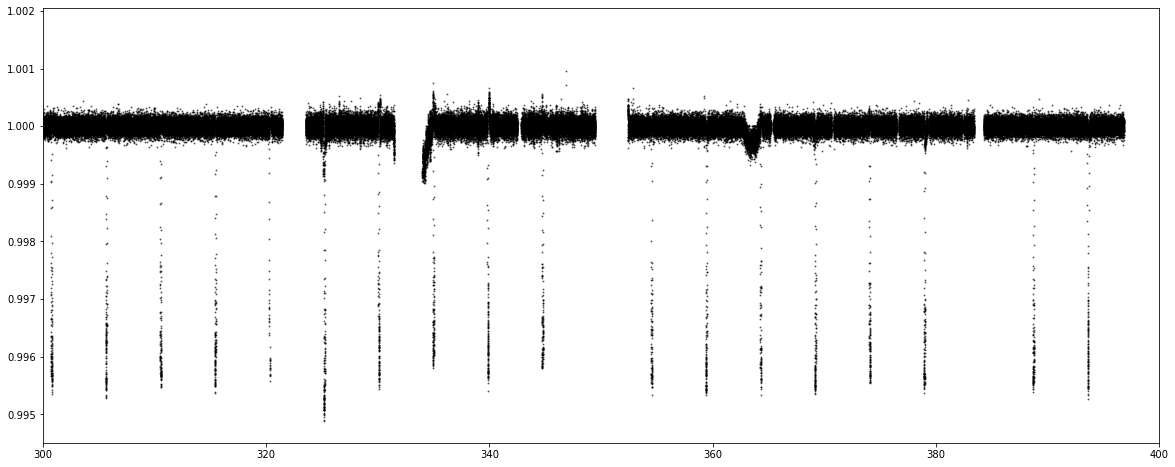

In [354]:
all_lc = all_lc[~clean_mask]
all_lc.flux.value[88000:129000] = np.nan
all_lc.flux.value[615000:690000] = np.nan
all_lc = all_lc.remove_nans()
clean_mask1 = (all_lc.time.value>1319) & (all_lc.time.value<1325)
all_lc = all_lc[~clean_mask1]
clean_mask2 = (all_lc.time.value>1347) & (all_lc.time.value<1353)
all_lc = all_lc[~clean_mask2]
clean_mask3 = (all_lc.time.value>331.5) & (all_lc.time.value<334)
all_lc = all_lc[~clean_mask3]
clean_mask4 = (all_lc.time.value>860) & (all_lc.time.value<880)
all_lc = all_lc[~clean_mask4]
tranmask = all_lc.create_transit_mask(transit_time=planet_t0.value, period=np.float64(planet_period), duration=np.float64(planet_dur))
plt.figure(figsize=(20, 8))
plt.plot(all_lc.time.value,all_lc.flatten(mask=tranmask).flux, "k.", ms=2, alpha=0.5)
plt.xlim(300,400)

In [355]:
starry.config.lazy = True
with pm.Model() as model:

    # These are the variables we're solving for;
    # here we're placing wide Gaussian priors on them.
    # offset = pm.Normal("offset", 0.0, 50.0, testval=0.11)()
    # log_amp = pm.Normal("log_amp", -4.0, 2.0, testval=-3.91)
    # u1 = pm.Uniform("u1", lower=0.638,upper=0.7)
    # u2 = pm.Uniform("u2", lower=0.033,upper=0.064) 
    # rp = pm.Uniform("rp", lower=0.03232321,upper=0.04632)
    # mass_p = pm.Uniform("mp", lower=7.0000e-5,upper=7.5e-5) 
    # The log period; also tracking the period itself
    # logP = pm.Normal("logP", mu=np.log(np.random.uniform(4, 5)), sd=0.1, testval=np.log(4.888))
    # period = pm.Deterministic("period", pm.math.exp(logP))
    period = pm.Uniform("porb", lower=4,upper=5, testval=4.888)
    t0 = pm.Uniform("t0", lower=124,upper=125, testval=124.85) 

    # Instantiate the star; all its parameters are assumed
    # to be known exactly
    A = starry.Primary(
        starry.Map(ydeg=0, udeg=2, amp=1.0), m=0.809, r=0.683, prot=1.0
    )
    A.map[1] = 0.646
    A.map[2] = 0.048

    # Instantiate the planet. Everything is fixed except for
    # its luminosity and the hot spot offset.
    b = starry.Secondary(
        starry.Map(ydeg=1, udeg=0, obl=0.0, amp=0),
        m=7.0257708e-5,  # mass in solar masses
        r=0.039974684,   # radius in solar radii
        inc=88.99, # orbital inclination
        porb=period,  # orbital period in days
        prot=1,
        w=-162.149,  # Argument of periastron (little omega)
        ecc=0.265,  # eccentricity
        Omega=106, 
        t0=t0, # 
    )
    #b.map[1, 0] = 0.5
    # b.theta0 = 180.0 + offset

    # Instantiate the system as before
    sys = starry.System(A, b)

    # Our model for the flux
    flux_model = pm.Deterministic("flux_model", sys.flux(all_lc.time.value))

    # This is how we tell `pymc3` about our observations;
    # we are assuming they are ampally distributed about
    # the true model. This line effectively defines our
    # likelihood function.
    # pm.Normal("obs", flux_model, sd=all_lc.flux_err, observed=np.array(all_lc.flatten(mask=tranmask).flux))
    pm.Normal("obs", flux_model, sd=np.array(all_lc.flux_err), observed=np.array(all_lc.flatten(mask=tranmask).flux))

In [356]:
np.sum(np.array(all_lc.flux))

1172577.2

In [357]:
pmx.eval_in_model(flux_model, model=model)

array([1., 1., 1., ..., 1., 1., 1.])

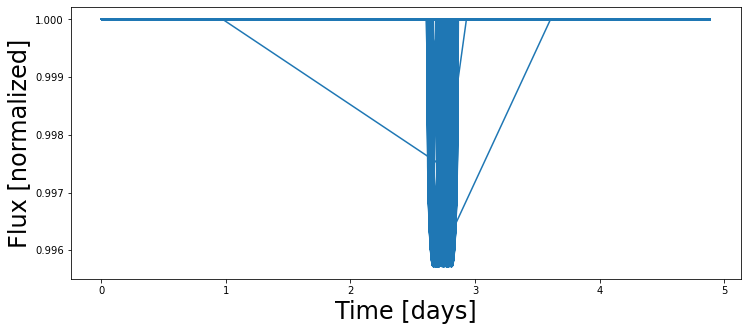

In [358]:
plt.figure(figsize=(12, 5))
plt.plot(all_lc.time.value%np.float64(planet_period), pmx.eval_in_model(flux_model, model=model))
plt.xlabel("Time [days]", fontsize=24)
plt.ylabel("Flux [normalized]", fontsize=24);

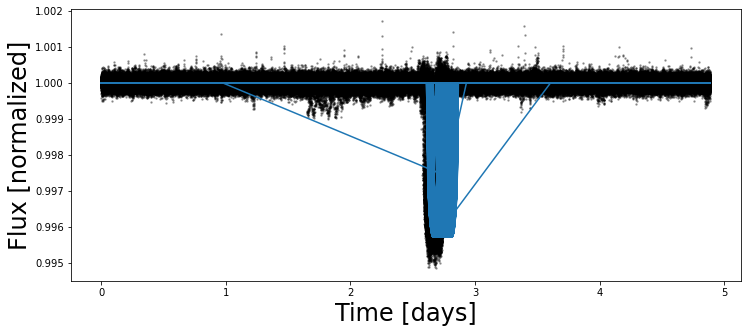

In [359]:
plt.figure(figsize=(12, 5))
plt.plot(all_lc.time.value%np.float64(planet_period), all_lc.flatten(mask=tranmask).flux.value, "k.", alpha=0.3, ms=3)
plt.plot(all_lc.time.value%np.float64(planet_period), pmx.eval_in_model(flux_model, model=model))
plt.xlabel("Time [days]", fontsize=24)
plt.ylabel("Flux [normalized]", fontsize=24);

In [360]:
with model:
    map_soln = pmx.optimize()

WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: <starry._core.ops.rotation.tensordotRzGradientOp object at 0x191877b50>.1
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor1.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: <starry._core.ops.rotation.tensordotRzGradientOp object at 0x191877b50>.1
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor1.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor1.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor1.0
optimizing logp for variables: [t0, porb]


message: Desired error not necessarily achieved due to precision loss.
logp: -22259949.133864846 -> 8895924.786262117


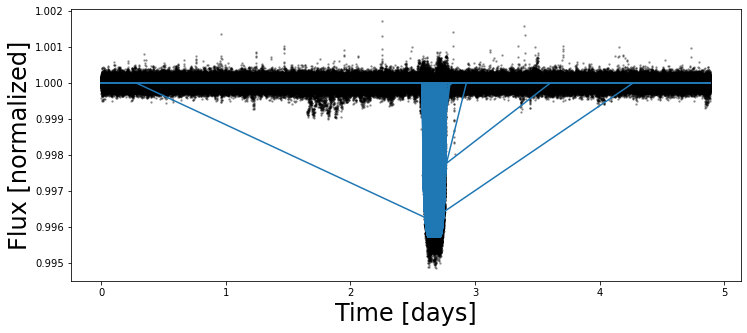

In [361]:
plt.figure(figsize=(12, 5))
plt.plot(all_lc.time.value%np.float64(planet_period), all_lc.flatten(mask=tranmask).flux, "k.", alpha=0.3, ms=3)
plt.plot(all_lc.time.value%np.float64(planet_period), map_soln['flux_model'])
plt.xlabel("Time [days]", fontsize=24)
plt.ylabel("Flux [normalized]", fontsize=24);

In [31]:
# with model:
#     trace = pmx.sample(
#         tune=250,
#         draws=500,
#         start=map_soln,
#         chains=4,
#         cores=1,
#         target_accept=0.9,
#     )

In [362]:
starry.config.lazy = False
starry.config.quiet = True
A = starry.Primary(starry.Map(ydeg=0, udeg=2, amp=1.0), m=0.809, r=0.683, prot=1.0)
trueu1 = 0.646
trueu2 = 0.048
A.map[1] = trueu1
A.map[2] = trueu2

b = starry.Secondary(
    starry.Map(ydeg=1, udeg=0, obl=0.0, amp=0),
    m=7.0257708e-5,  # mass in solar masses
    r=0.039974684,  # radius in solar radii
    inc=88.99, # orbital inclination
    porb=map_soln['porb'],  # orbital period in days
    prot=1,
    w=-162.149,  # Argument of periastron (little omega)
    ecc=0.265,  # eccentricity
    Omega=106, # I think it's lambda in Morris 2017
    t0=map_soln['t0'],
)

In [363]:
map_soln['porb']

array(4.88780274)

In [364]:
map_soln['t0']

array(124.81312568)

In [371]:
all_lc.tail()

time,flux,flux_err,quality,timecorr,centroid_col,centroid_row,cadenceno,sap_flux,sap_flux_err,sap_bkg,sap_bkg_err,pdcsap_flux,pdcsap_flux_err,sap_quality,psf_centr1,psf_centr1_err,psf_centr2,psf_centr2_err,mom_centr1,mom_centr1_err,mom_centr2,mom_centr2_err,pos_corr1,pos_corr2
,,,,d,pix,pix,,electron / s,electron / s,electron / s,electron / s,electron / s,electron / s,,pix,pix,pix,pix,pix,pix,pix,pix,pix,pix
Time,float32,float32,int32,float32,float64,float64,int32,float32,float32,float32,float32,float32,float32,int32,float64,float32,float64,float32,float64,float32,float64,float32,float32,float32
1590.975368489031,9.9842632e-01,8.8989764e-05,0,-2.416510e-04,555.43592,821.86174,2164367,2.8656375e+06,2.3244954e+02,7.7800513e+03,2.3241408e+00,2.8734218e+06,2.5610815e+02,0,———,———,———,———,555.43592,6.7331981e-05,821.86174,1.7915845e-04,-9.7688334e-04,-1.4776380e-03
1590.9767308358932,9.9849474e-01,8.9274115e-05,0,-2.416041e-04,555.43760,821.86058,2164369,2.8656395e+06,2.3245459e+02,7.7802231e+03,2.3242829e+00,2.8736188e+06,2.5692651e+02,0,———,———,———,———,555.43760,6.7324108e-05,821.86058,1.7920477e-04,-1.0418282e-03,-1.5512145e-03
1590.9910348278645,9.9924296e-01,9.0550246e-05,0,-2.411121e-04,555.43953,821.85844,2164390,2.8664152e+06,2.3251494e+02,7.7806221e+03,2.3235004e+00,2.8757720e+06,2.6059915e+02,0,———,———,———,———,555.43953,6.7313209e-05,821.85844,1.7983581e-04,-8.2904339e-04,-1.2532609e-03
1591.0019331027506,9.9865025e-01,8.7184009e-05,0,-2.407373e-04,555.43457,821.86246,2164406,2.8655762e+06,2.3243814e+02,7.7805474e+03,2.3222888e+00,2.8740662e+06,2.5091129e+02,0,———,———,———,———,555.43457,6.7328823e-05,821.86246,1.7909841e-04,-4.2505012e-04,-7.3685148e-04
1591.0101067839205,9.9789053e-01,8.2613122e-05,0,-2.404561e-04,555.43694,821.86101,2164418,2.8659018e+06,2.3247791e+02,7.7804912e+03,2.3213799e+00,2.8718798e+06,2.3775650e+02,0,———,———,———,———,555.43694,6.7310502e-05,821.86101,1.7932963e-04,-1.2205610e-04,-3.4954556e-04


In [374]:
all_lc['time'].format = 'iso'

In [381]:
all_lc.head()

time,flux,flux_err,quality,timecorr,centroid_col,centroid_row,cadenceno,sap_flux,sap_flux_err,sap_bkg,sap_bkg_err,pdcsap_flux,pdcsap_flux_err,sap_quality,psf_centr1,psf_centr1_err,psf_centr2,psf_centr2_err,mom_centr1,mom_centr1_err,mom_centr2,mom_centr2_err,pos_corr1,pos_corr2
,,,,d,pix,pix,,electron / s,electron / s,electron / s,electron / s,electron / s,electron / s,,pix,pix,pix,pix,pix,pix,pix,pix,pix,pix
Time,float32,float32,int32,float32,float64,float64,int32,float32,float32,float32,float32,float32,float32,int32,float64,float32,float64,float32,float64,float32,float64,float32,float32,float32
2009-05-02 00:41:10.902,9.9879408e-01,1.7174082e-04,0,3.223656e-04,555.58158,821.86413,5500,2.9128242e+06,2.3517690e+02,6.8893467e+03,2.1677258e+00,2.9205592e+06,5.0218484e+02,0,———,———,———,———,555.58158,6.6864952e-05,821.86413,1.9141044e-04,2.5442394e-04,-3.2165432e-03
2009-05-02 00:44:07.459,9.9873668e-01,1.5708857e-04,0,3.224425e-04,555.58274,821.86521,5503,2.9126892e+06,2.3516835e+02,6.8900498e+03,2.1674051e+00,2.9203915e+06,4.5934039e+02,0,———,———,———,———,555.58274,6.6847140e-05,821.86521,1.9152994e-04,2.8717262e-04,-3.1886860e-03
2009-05-02 00:45:06.317,9.9864805e-01,1.5296284e-04,0,3.224682e-04,555.58130,821.86659,5504,2.9124402e+06,2.3514540e+02,6.8902847e+03,2.1672983e+00,2.9201322e+06,4.4727640e+02,0,———,———,———,———,555.58130,6.6857276e-05,821.86659,1.9131499e-04,2.9808990e-04,-3.1793993e-03
2009-05-02 00:46:05.166,9.9875557e-01,1.4920715e-04,0,3.224938e-04,555.58338,821.86437,5505,2.9127630e+06,2.3516986e+02,6.8905190e+03,2.1671915e+00,2.9204468e+06,4.3629446e+02,0,———,———,———,———,555.58338,6.6841698e-05,821.86437,1.9159318e-04,3.0900558e-04,-3.1701140e-03
2009-05-02 00:47:04.015,9.9870324e-01,1.4579581e-04,0,3.225195e-04,555.58280,821.86600,5506,2.9126190e+06,2.3516171e+02,6.8907529e+03,2.1670847e+00,2.9202938e+06,4.2631943e+02,0,———,———,———,———,555.58280,6.6839348e-05,821.86600,1.9150582e-04,3.1992130e-04,-3.1608287e-03


In [384]:
all_lc['time'].value[0].split('-')[0]

'2009'

In [386]:
mask3 = [i.split('-')[0]=='2010' and i.split('-')[1]=='04' and i.split('-')[2].split(' ')[0]=='18' for i in all_lc['time'].value]
mask1 = [i.split('-')[0]=='2009' and i.split('-')[1]=='12' and i.split('-')[2].split(' ')[0]=='02' for i in all_lc['time'].value]
mask2 = [i.split('-')[0]=='2009' and i.split('-')[1]=='12' and i.split('-')[2].split(' ')[0]=='31' for i in all_lc['time'].value]
mask4 = [i.split('-')[0]=='2012' and i.split('-')[1]=='01' and i.split('-')[2].split(' ')[0]=='08' for i in all_lc['time'].value]

In [387]:
all_lc['time'].format = 'bkjd'

In [388]:
lc1 = all_lc[mask1]
lc2 = all_lc[mask2]
lc3 = all_lc[mask3]
lc4 = all_lc[mask4]

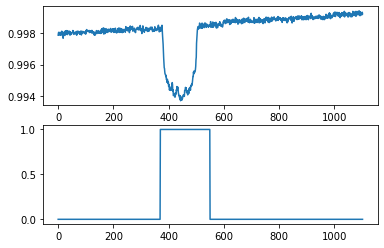

In [399]:
mask3 = np.zeros(len(lc3.flux), dtype=bool)
mask3[370:550] = 1
fig, ax = plt.subplots(2)
ax[0].plot(lc3.flux)
ax[1].plot(mask3)

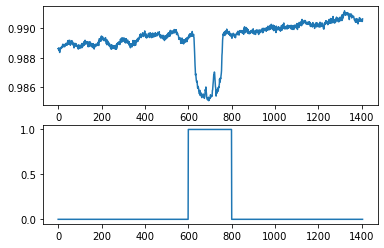

In [410]:
mask1 = np.zeros(len(lc1.flux), dtype=bool)
mask1[600:800] = 1
fig, ax = plt.subplots(2)
ax[0].plot(lc1.flux)
ax[1].plot(mask1)

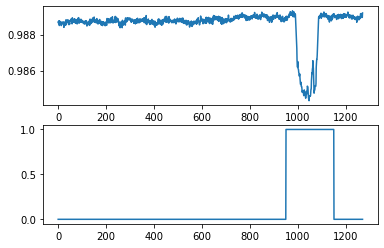

In [409]:
mask2 = np.zeros(len(lc2.flux), dtype=bool)
mask2[950:1150] = 1
fig, ax = plt.subplots(2)
ax[0].plot(lc2.flux)
ax[1].plot(mask2)

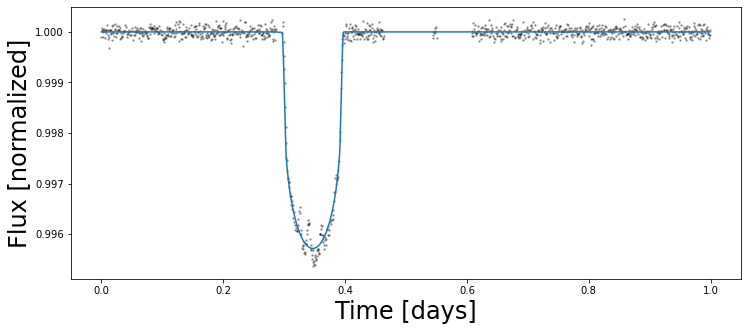

In [400]:
sys = starry.System(A, b)
# flux_true = sys.flux(lc3.time.value)
plt.figure(figsize=(12, 5))
plt.plot(lc3.fold(period=map_soln['porb']).time.value, lc3.flatten(mask=mask3).flux, "k.", alpha=0.3, ms=3)
plt.plot(lc3.fold(period=map_soln['porb']).time.value, sys.flux(lc3.time.value))
plt.xlabel("Time [days]", fontsize=24)
plt.ylabel("Flux [normalized]", fontsize=24);

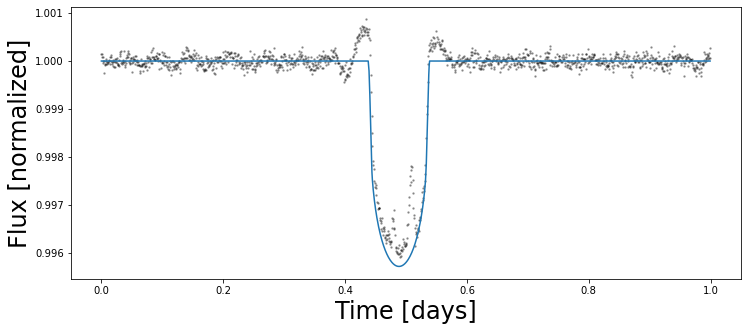

In [404]:
sys = starry.System(A, b)
# flux_true = sys.flux(lc1.time.value)
plt.figure(figsize=(12, 5))
plt.plot(lc1.fold(period=map_soln['porb']).time.value, lc1.flatten(mask=mask1).flux, "k.", alpha=0.3, ms=3)
plt.plot(lc1.fold(period=map_soln['porb']).time.value, sys.flux(lc1.time.value))
plt.xlabel("Time [days]", fontsize=24)
plt.ylabel("Flux [normalized]", fontsize=24);

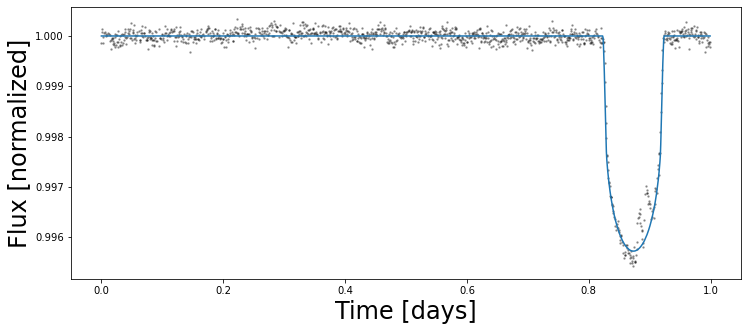

In [393]:
sys = starry.System(A, b)
# flux_true = sys.flux(lc4.time.value)
plt.figure(figsize=(12, 5))
plt.plot(lc4.fold(period=map_soln['porb']).time.value, lc4.normalize().flux, "k.", alpha=0.3, ms=3)
plt.plot(lc4.fold(period=map_soln['porb']).time.value, sys.flux(lc4.time.value))
plt.xlabel("Time [days]", fontsize=24)
plt.ylabel("Flux [normalized]", fontsize=24);

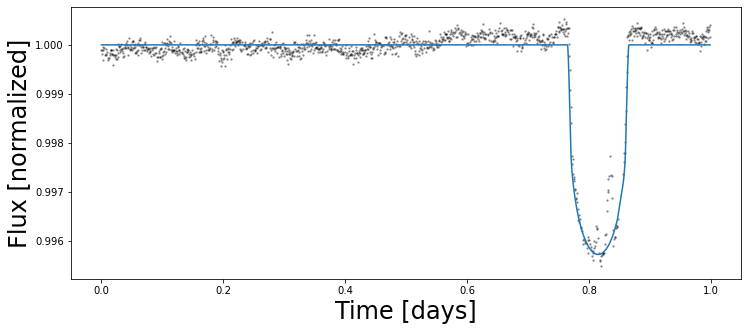

In [411]:
sys = starry.System(A, b)
# flux_true = sys.flux(lc4.time.value)
plt.figure(figsize=(12, 5))
plt.plot(lc2.fold(period=map_soln['porb']).time.value, lc2.normalize().flux, "k.", alpha=0.3, ms=3)
plt.plot(lc2.fold(period=map_soln['porb']).time.value, sys.flux(lc2.time.value))
plt.xlabel("Time [days]", fontsize=24)
plt.ylabel("Flux [normalized]", fontsize=24);

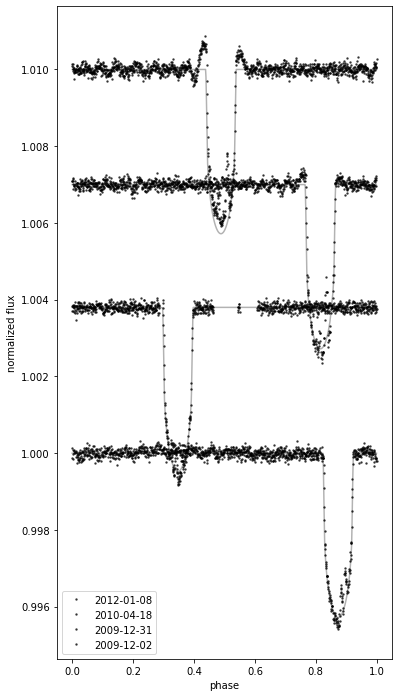

In [412]:
fig = plt.subplots(figsize=(6, 12), sharex=True)

plt.plot(lc4.fold(period=map_soln['porb']).time.value, lc4.normalize().flux, "k.", alpha=0.6, ms=3, label="2012-01-08")
plt.plot(lc4.fold(period=map_soln['porb']).time.value, sys.flux(lc4.time.value), color='black', alpha=0.3)

plt.plot(lc3.fold(period=map_soln['porb']).time.value, lc3.flatten(mask=mask3).flux+0.0038, "k.", alpha=0.6, ms=3,label='2010-04-18')
plt.plot(lc3.fold(period=map_soln['porb']).time.value, sys.flux(lc3.time.value)+0.0038, color='black', alpha=0.3)

plt.plot(lc2.fold(period=map_soln['porb']).time.value, lc2.flatten(mask=mask2).flux+0.007, "k.", alpha=0.6, ms=3,label='2009-12-31')
plt.plot(lc2.fold(period=map_soln['porb']).time.value, sys.flux(lc2.time.value)+0.007, color='black',alpha=0.3)

plt.plot(lc1.fold(period=map_soln['porb']).time.value, lc1.flatten(mask=mask1).flux+0.010, "k.", alpha=0.6, ms=3,label='2009-12-02')
plt.plot(lc1.fold(period=map_soln['porb']).time.value, sys.flux(lc1.time.value)+0.010, color='black',alpha=0.3)

# plt.xlim(-0.1,0.1)
plt.xlabel("phase")
plt.ylabel("normalized flux");
plt.legend()
plt.show()